# > Json Data 정제 및 json 저장

In [1]:
import json
import pandas as pd
from collections import defaultdict

from PIL import Image, ImageOps, ExifTags
import cv2
import imagesize

from tqdm import tqdm
import os
import os.path as osp
import shutil

In [2]:
merge_dataset_path = '/opt/ml/input/data/merge_dataset'

if os.path.exists(merge_dataset_path):
    shutil.rmtree(merge_dataset_path)
    print("기존 Directory 삭제!")

In [3]:
def makedirs(path):
    try:
        os.makedirs(path)
    except OSError:
        print(f"Directory is already exist.({path})")
        if not os.path.isdir(path): 
            raise

makedirs(osp.join(merge_dataset_path, 'images'))
makedirs(osp.join(merge_dataset_path, 'ufo'))

In [4]:
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation]=='Orientation':
        break

In [5]:
auto_rotated_images=[]

In [6]:
def stack_json_data(target_json, target_images, merge_dataset_path):
    category = {}
    file_info = {}
    make_frame = defaultdict(list)

    # target 에 존재하는 train.json 파일을 엽니다.
    with open(target_json, 'r') as f:
        json_datas = json.load(f) # python dict 처럼 접근하게끔 변환

        # 이미지 정보 중 파일 경로와 아이디만 추출해서 file_info 에 저장
        for images_idx, images_item in tqdm(enumerate(json_datas['images'])):
            new_image_info = dict()            

            if ('img_h' not in json_datas['images'][images_item]) or ('img_w' not in json_datas['images'][images_item]):
                image = Image.open(osp.join(target_images, images_item))
                new_image_info['img_w'], new_image_info['img_h'] = image.width, image.height

                if image._getexif() != None:
                    exif=dict(image._getexif().items())
                    if orientation in exif.keys():
                        if (exif[orientation] == 6) or (exif[orientation] == 8): # 6 : 270, 8 : 90
                            new_image_info['img_h'], new_image_info['img_w'] = image.width, image.height
                            auto_rotated_images.append(images_item)
                
            else:
                if (isinstance(json_datas['images'][images_item]['img_h'], int) == False) or (isinstance(json_datas['images'][images_item]['img_h'], int) == False):
                    image = Image.open(osp.join(target_images, images_item))
                    new_image_info['img_w'], new_image_info['img_h'] = image.width, image.height

                    if image._getexif() != None:
                        exif=dict(image._getexif().items())
                        if orientation in exif.keys():
                            if (exif[orientation] == 6) or (exif[orientation] == 8): # 6 : 270, 8 : 90
                                new_image_info['img_h'], new_image_info['img_w'] = image.width, image.height
                                auto_rotated_images.append(images_item)
                else:
                    new_image_info['img_w'] = json_datas['images'][images_item]['img_w']
                    new_image_info['img_h'] = json_datas['images'][images_item]['img_h']
                
            new_image_info['paragraphs'] = dict()
            new_image_info['words'] = dict()
            
            normal_index = 0
            if len(json_datas['images'][images_item]['words']) == 0:
                continue

            for words_item in json_datas['images'][images_item]['words']:
                for words_item in json_datas['images'][images_item]['words']:
                    isError = False
                    each_word_info = dict()

                    # illegibility가 False 이면서, transcription 이 Null 인 경우 제거
                    if (json_datas['images'][images_item]['words'][words_item]['illegibility'] == False) and \
                        (json_datas['images'][images_item]['words'][words_item]['transcription'] == None):
                        continue

                    # point가 4개 미만이면 제거
                    if len(json_datas['images'][images_item]['words'][words_item]['points']) < 4:
                        continue

                    # point 개수가 홀수면 제거
                    if len(json_datas['images'][images_item]['words'][words_item]['points']) % 2 != 0:
                        continue

                    new_points = []
                    # 좌표 값 오류 수정 작업 (대상 : 0보다 작거나 Image Size 보다 큰 경우)
                    for each_ann_points_idx, (coordi_x, coordi_y) in enumerate(json_datas['images'][images_item]['words'][words_item]['points']):
                        if coordi_x < 0:
                            coordi_x = 0
                        elif coordi_x > new_image_info['img_w']:
                            coordi_x = new_image_info['img_w']

                        if coordi_y < 0:
                            coordi_y = 0
                        elif coordi_y > new_image_info['img_h']:
                            coordi_y = new_image_info['img_h']

                        new_points.append([coordi_x, coordi_y])

                    each_word_info['points'] = new_points
                
                # 공백이 있는 transcription 일 경우 제거
                # if " " in json_datas['images'][images_item]['words'][words_item]['transcription']:
                #     continue

                each_word_info['transcription'] = json_datas['images'][images_item]['words'][words_item]['transcription']
                each_word_info['language'] = json_datas['images'][images_item]['words'][words_item]['language']
                each_word_info['illegibility'] = json_datas['images'][images_item]['words'][words_item]['illegibility']
                each_word_info['orientation'] = json_datas['images'][images_item]['words'][words_item]['orientation']
                each_word_info['word_tags'] = json_datas['images'][images_item]['words'][words_item]['word_tags']

                new_image_info['words'][normal_index] = each_word_info
                normal_index += 1

            # 정제 후 Point가 1개도 없으면 제거
            if len(new_image_info['words']) == 0:
                continue
            
            new_image_info['chars'] = dict()
            new_image_info['tags'] = dict()
            new_image_info['relations'] = dict()
            new_image_info['license_tag'] = json_datas['images'][images_item]['license_tag']
            new_info['images'][images_item] = new_image_info

            shutil.copyfile(osp.join(target_images, images_item), osp.join(merge_dataset_path + '/images', images_item))

In [7]:
new_info = dict()
new_info['images'] = dict()

In [8]:
# 기본 제공 dataset 에 대한 json 전처리(Format 통일, 오류 제거, Noise 수정) 후 저장 (+ 해당되는 Image 복사)
target_json = '/opt/ml/input/data/ICDAR17_Korean/ufo/train.json'
target_images = '/opt/ml/input/data/ICDAR17_Korean/images'
stack_json_data(target_json, target_images, merge_dataset_path)

# 추가 dataset 에 대한 json 전처리(Format 통일, 오류 제거, Noise 수정) 후 저장 (+ 해당되는 Image 복사)
target_json = '/opt/ml/input/data/dataset_revised/ufo/annotation.json'
target_images = '/opt/ml/input/data/dataset_revised/images'
stack_json_data(target_json, target_images, merge_dataset_path)

536it [00:00, 1072.31it/s]
1650it [00:11, 142.22it/s]


In [9]:
print(len(new_info['images']))

2077


In [10]:
with open(osp.join(merge_dataset_path, 'ufo/merge_dataset.json'), 'w') as outfile:
    json.dump(new_info, outfile, indent=2)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
image_keys = list(new_info['images'])

In [13]:
def draw_bbox(image, bbox, color=(0, 0, 0), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 0), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)

In [14]:
SAMPLE_IDX = 500

In [15]:
image_keys[SAMPLE_IDX]

'img_1194.jpg'

In [16]:
len(auto_rotated_images)

469

Image:	(4032, 3024, 3)
Bboxes:	(32, 4, 2)
Labels:	(32,)


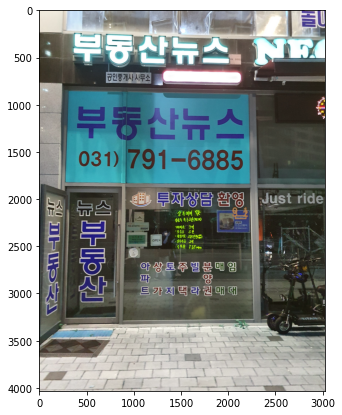

In [17]:
images_item = '1632025728267-3.jpg'
# images_item = image_keys[SAMPLE_IDX]
image_fpath = osp.join(merge_dataset_path + '/images', images_item)
image = cv2.imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in new_info['images'][images_item]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=object), np.array(labels, dtype=object)

print('Bboxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

vis = image.copy()
draw_bboxes(vis, bboxes, color=(0,128,255), double_lined=True, thickness=2, thickness_sub=10, write_point_numbers=True)

plt.figure(figsize=(10, 7))
plt.imshow(vis)

SAMPLE_IDX += 1

In [18]:
image_set = new_info['images']

df_keys = []
df_values = []

for k,v in image_set.items():
    df_keys.append(k)
    # transpose data for mapping image name
    df_values.append(pd.DataFrame(v['words']).T)
    
df = pd.concat(df_values, keys=df_keys)
print(f'len(df_keys) : {len(df_keys)}\t len(df_values) : {len(df_values)}')

#divide index
df['image_name'] = df.index.get_level_values(0)
df['point_name'] = df.index.get_level_values(1).astype(int)
#change index
df.index = (i for i in range(len(df)))
a= set(df['image_name'].values)
df = df.loc[df.illegibility == False]
b= set(df.image_name.values)
print(a-b)
df.head()

len(df_keys) : 2077	 len(df_values) : 2077
{'IMG_3614.jpg', '20210911_130738.jpg', 'IMG_7432.JPG', 'IMG_6737.jpg', '20210918_120511.jpeg', 'img_4477.jpg', 'IMG_3488.jpg', 'img_4488.jpg', 'IMG_8115.jpg', 'img_4786.jpg', 'IMG_5140.jpg', '20210925_135858.jpg', 'IMG_4347.jpg', '8230AED3-FC15-4F56-9245-9FF36780D5F6.JPG', 'Screenshot_20200820-125728_Samsung Internet.png', '61207744103__3CEA715E-393A-41CD-889B-89655E01AE7B.jpg', '20210926_134224.jpg', 'IMG_6641.jpg', 'IMG_0144.JPG', 'IMG_8788.jpg', '20210305_194300.jpg', 'IMG_9565.jpeg', 'IMG_0762.jpeg', '20200916_001148.jpg', '20210915_192527.jpeg', '20210926_151805.jpg', 'IMG_7480.JPG', '1632650015287-9.jpg', 'img_4416.jpg', 'IMG_0354.jpeg', 'IMG_5455.jpeg', 'IMG_8294.jpg', 'IMG_0986.jpg', '20201030_181144.jpg', 'img_4761.jpg', 'IMG_0443.jpg', 'IMG_7423.JPG', '20210926_142321.jpg', 'img_1055.jpg', 'IMG_1422.jpg', '20210926_183812.jpg', '20210908_125422.jpg', '20210926_183220.jpg', '20181012_181505.jpg', 'IMG_5035.jpeg', '20210904_112906.jpg

,points,transcription,language,illegibility,orientation,word_tags,image_name,point_name
0,"[[455.0, 293.0], [1144.0, 310.0], [1129.0, 518...",자전거,[ko],False,Horizontal,None,img_4380.jpg,0
1,"[[455.0, 293.0], [1144.0, 310.0], [1129.0, 518...",자전거,[ko],False,Horizontal,None,img_4380.jpg,1
2,"[[455.0, 293.0], [1144.0, 310.0], [1129.0, 518...",자전거,[ko],False,Horizontal,None,img_4380.jpg,2
3,"[[318.0, 620.0], [1754.0, 664.0], [1752.0, 876...",주말관광문의,[ko],False,Horizontal,None,img_4583.jpg,0
4,"[[318.0, 620.0], [1754.0, 664.0], [1752.0, 876...",주말관광문의,[ko],False,Horizontal,None,img_4583.jpg,1


In [19]:
df['num_boxes'] = df['points'].apply(lambda x : int(len(x)/2 -1)) # n/2 -1
new_df = df['num_boxes'].groupby(df['image_name'])
# https://pandas.pydata.org/docs/reference/api/pandas.Series.sort_values.html
new_df.describe()
box_images_list = []
box_nums_list = []
for k,v in sorted(new_df.sum().items(), key=lambda x:x[1]):
    box_images_list.append(k)
    box_nums_list.append(v)
print(len(box_images_list))
print(len(box_nums_list))

TypeError: object of type 'float' has no len()

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

box_nums_list = np.array(box_nums_list)

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(box_images_list, box_nums_list)
print(skf)

In [ ]:
train_list = []
test_list = []
#index 값을 내뱉는 것인다.
for train_idx, test_idx in skf.split(box_images_list, np.array(box_nums_list)):
    print(f'TRAIN : {len(train_idx)}\t TEST : {len(test_idx)}')
    train_list.append(box_nums_list[train_idx])
    test_list.append(box_nums_list[test_idx])

In [ ]:
import copy
from tqdm import tqdm
box_images_list = np.array(box_images_list)
valid_set_index = [test_idx for _, test_idx in skf.split(box_images_list, box_nums_list)]

for i, indexes in tqdm(enumerate(valid_set_index)):
    valid_image_list = box_images_list[indexes]
    
    temp_image_set = copy.deepcopy(new_info)
    valid_json_dict = dict(images={})
    
    for image in valid_image_list:
        valid_json_dict['images'][image] = temp_image_set['images'][image]
        del(temp_image_set['images'][image])
        
    with open(osp.join(merge_dataset_path, f'ufo/train_{i}.json'), 'w') as f:
        json.dump(temp_image_set, f, indent=2)
        
    with open(osp.join(merge_dataset_path, f'ufo/valid_{i}.json'), 'w') as ff:
        json.dump(valid_json_dict, ff, indent=2)